In [1]:
import numpy as np

import aesara.tensor as at
from aesara.tensor.random.op import RandomVariable, default_shape_from_params

import sys

sys.path.insert(0, "/Users/larryshamalama/Documents/GitHub/pymc")

import pymc as pm

from pymc.distributions.continuous import assert_negative_support, UnitContinuous
from pymc.distributions.dist_math import betaln, normal_lcdf
from pymc.distributions.distribution import Continuous

from pymc.distributions import transforms

from pymc.aesaraf import floatX, intX

# a bunch of imports for testing and printing

from aesara.tensor.basic import get_vector_length
from aesara.tensor.random.utils import params_broadcast_shapes
from aesara.tensor.shape import shape_tuple

import aesara

import matplotlib.pyplot as plt
import scipy.stats as st

%config InlineBackend.figure_format = "retina"
%matplotlib inline

print(f"pymc version: {pm.__version__}")
print(f"Aesara version: {aesara.__version__}")
print(f"pymc location: {pm.__file__}")

pymc version: 4.0.0b2
Aesara version: 2.3.2
pymc location: /Users/larryshamalama/Documents/GitHub/pymc/pymc/__init__.py


In [2]:
M = 3; K = 19

In [3]:
def stick_glueing(weights):
    shape = tuple(weights.shape or ())
    
    denominator = np.cumsum(
        np.concatenate(
            [
                np.ones(shape=shape[:-1] + (1,)),
                - weights,
            ],
            axis=-1,
        ),
        axis=-1,
    )
    
    output = (weights/(denominator[..., :-1]))
    
    return output[..., :-1]

## Testing `rng_fn`

In [4]:
with pm.Model() as model:
    # check K = 5, something less crazy, 19 might run into precision issues quickly
    # check expectation of last bin
    # need upper bound to K with respect to M
    # if last value is 0, then inf would arise in one but not all
    
    # gradually grow α and see when it starts breaking
    sbw = pm.StickBreakingWeights(name="sbw", alpha=M, K=19, shape=[3,])
    prior = pm.sample_prior_predictive(samples=2000,)
    trace = pm.sample(draws=2000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sbw]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [5]:
trace.to_dict()["posterior"]["sbw"][0].shape

/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:454: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(


(2000, 20)

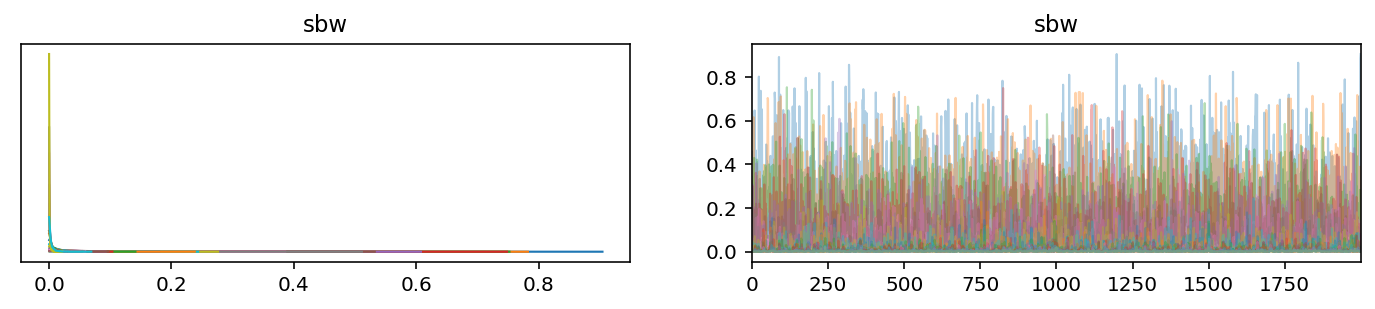

In [6]:
_ = pm.plot_trace(trace)

/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:454: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(


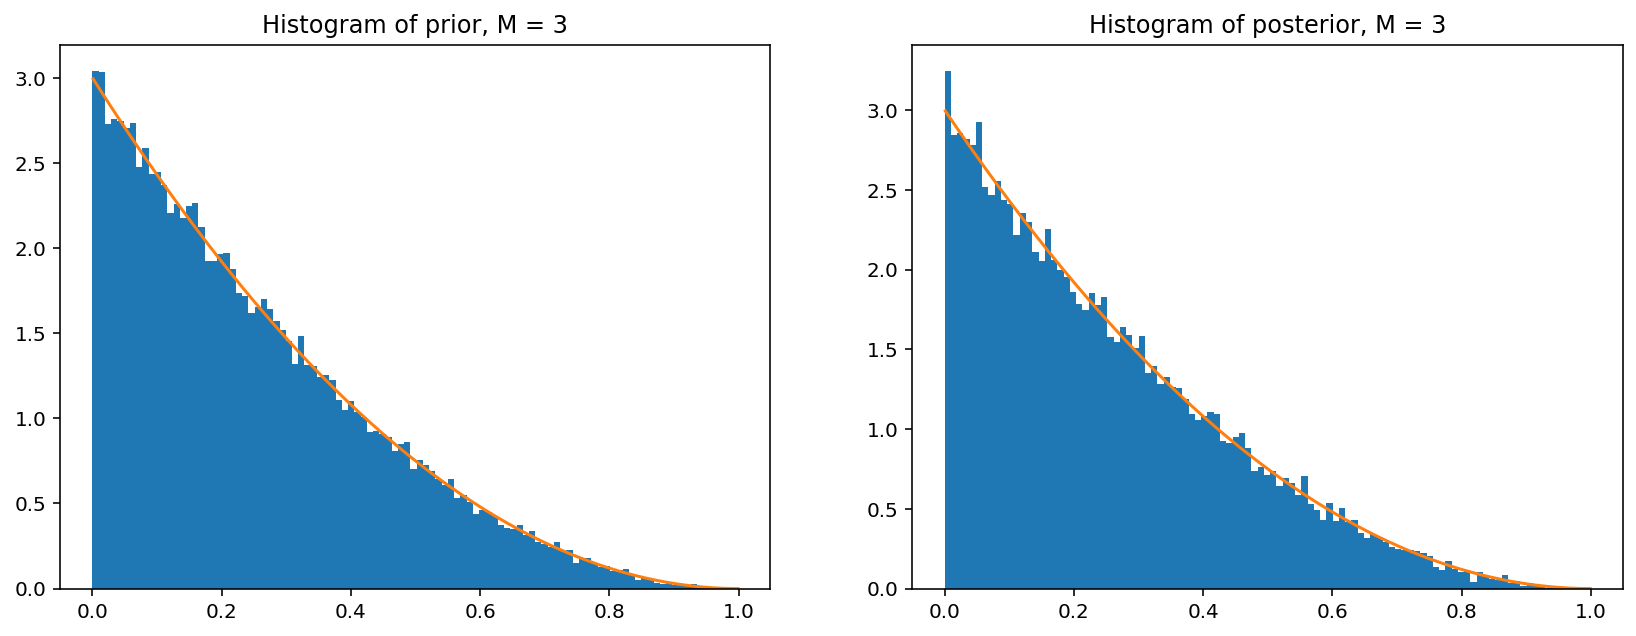

In [7]:
prior_beta_draws = stick_glueing(prior.to_dict()["prior"]["sbw"]).reshape(-1,)
post_beta_draws = stick_glueing(trace.to_dict()["posterior"]["sbw"][0]).reshape(-1,)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

x_plot = np.linspace(start=0.001, stop=0.999, num=10001)

_ = axes[0].hist(prior_beta_draws, bins=100, density=True)
_ = axes[0].plot(
    x_plot,
    st.beta.pdf(x_plot, a=1., b=M),
)
_ = axes[0].set_title(f"Histogram of prior, M = {M}", fontsize=12)

_ = axes[1].hist(post_beta_draws, bins=100, density=True)
_ = axes[1].plot(
    x_plot,
    st.beta.pdf(x_plot, a=1., b=M),
)
_ = axes[1].set_title(f"Histogram of posterior, M = {M}", fontsize=12)

## Hierarchical Sample

In [8]:
with pm.Model() as model:
    α = pm.Gamma(name="α", alpha=4., beta=2.)
    sbw = StickBreakingWeights(name="sbw", alpha=α, K=11, shape=[3,])
    prior = pm.sample_prior_predictive(samples=2000,)
    trace = pm.sample(draws=2000, chains=1)

NameError: name 'StickBreakingWeights' is not defined